In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from dateutil import parser
from datetime import datetime


# CLEAN dataframe for training
## Scale
* Minutes for arrival
* Time of day (minutes since midnight)
* Day of week (0-6)
* Day of month (0-30)
* Day of the year (0-364)
* Month (0-11)
* Year
* Lat
* Long

## Categorical
* Crime category
* Geo Code



In [2]:
incidents_df = pd.read_csv("data/Police_Incidents_Since_1988.csv", sep = None, dtype={'INCIDENT': np.str_, 'DATE OCCURRED': np.str_, 'TIME OCCURED' : np.str_, 'YEAR OCCURRED': np.int_, 'MONTH OCCURRED': np.int_, 'DATE REPORTED': np.str_, 'TIME ARRIVED': np.str_, 'DATE ARRIVED': np.str_, 'GEO CODE': np.str_, 'HOUSE NUMBER BLOCK': np.str_, 'STREET': np.str_, 'CRIME CODE': np.float64, 'CRIME DESCRIPTION': np.str_, 'CRIME CATEGORY': np.str_, 'CRIME CATEGORY DESCRIPTION': np.str_, 'CSA DESCRIPTION': np.str_, 'PLACE CODE DESCRIPTION': np.str_, 'WEAPONS CODE 1': np.str_, 'WEAPON 1 DESCRIPTION': np.str_, 'WEAPONS CODE 2': np.str_, 'WEAPON 2 DESCRIPTION': np.str_, 'WEAPONS CODE 3': np.str_, 'WEAPON 3 DESCRIPTION': np.str_, 'BIAS CODE': np.float64, 'BIAS DESCRIPTION': np.str_, 'STATUS CODE': np.float64, 'STATUS DESCRIPTION': np.str_, 'COUNTER': int, 'MAPPING ADDRESS': np.str_}, engine = 'python')

In [3]:
#pd.set_option('display.max_columns', None)

#incidents_df.head()

In [4]:
length = len(incidents_df)
latitude = [np.nan] * length
longitude =[np.nan] * length
total_min =[np.nan] * length
day_of_week =[np.nan] * length
day_of_month =[np.nan] * length
day_of_year =[np.nan] * length

time =[np.nan] * length
for index in range(length):
    if index %50000==0:
        print("currently on row ", index, "out of ", length)

    #lat/long
    value = str(incidents_df['MAPPING ADDRESS'][index])
    left_ind = value.find('(')
    mid_ind = value.find(',', left_ind)
    right_ind = value.find(')')
    if left_ind!=-1 and mid_ind !=-1 and right_ind !=-1:
        latitude[index] = float(value[left_ind+1: mid_ind])
        longitude[index] = float(value[mid_ind+1:right_ind])

    arrive = (str(incidents_df['DATE REPORTED'][index]) + ' ' + str(incidents_df['TIME REPORTED'][index]))
    report = (str(incidents_df['DATE ARRIVED'][index]) + ' ' + str(incidents_df['TIME ARRIVED'][index]))
    
    #response time
    try:
        a = parser.parse(arrive)
        b = parser.parse(report)
        delt = b-a
        elapsed = delt.total_seconds()//60
        if elapsed>=0 and elapsed<300:  #ignoring 0 minutes because it was probably not a caller
            time[index] = int(elapsed)
    except:
        pass
    
    #total minutes
    try:
        a = parser.parse(str(incidents_df['DATE REPORTED'][index]))
        
        # day_of_week
        day_of_week[index] = int(a.weekday())
        
        # day_of_month
        day_of_month[index] = int(a.day)
        
        # day_of_year
        day_of_year[index] = int(a.timetuple().tm_yday)
    except:
        pass
    
    try:
        a = parser.parse(incidents_df['TIME REPORTED'][index])
        
        # total_min
        total_min[index] = int(a.hour*60+a.minute)
    except:
        pass
    
print('done!')

incidents_df['LATITUDE'] = latitude
incidents_df['LONGITUDE'] = longitude
incidents_df['RESPONSE TIME'] = time
incidents_df['MINS OF DAY'] = total_min
incidents_df['DAY OF WEEK'] = day_of_week
incidents_df['DAY OF MONTH'] = day_of_month
incidents_df['DAY OF YEAR'] = day_of_year
pd.set_option('display.max_rows', None)
# incidents_df.head()

currently on row  0 out of  474609
currently on row  50000 out of  474609
currently on row  100000 out of  474609
currently on row  150000 out of  474609
currently on row  200000 out of  474609
currently on row  250000 out of  474609
currently on row  300000 out of  474609
currently on row  350000 out of  474609
currently on row  400000 out of  474609
currently on row  450000 out of  474609
done!


## Two dataframes are created:
* cleaned_data.csv has the cleaned data
* cleaned_data_no_zeros.csv has cleaned data where all rows have response time > 0

In [5]:
streamlined_df = incidents_df[['CRIME CATEGORY DESCRIPTION','RESPONSE TIME','MINS OF DAY', 'DAY OF WEEK', 'DAY OF MONTH', 'DAY OF YEAR', 'MONTH OCCURRED', 'YEAR OCCURRED','GEO CODE', 'LATITUDE', 'LONGITUDE']]
streamlined_df = streamlined_df[streamlined_df['RESPONSE TIME'].notna()]
streamlined_df.to_csv('data/cleaned_data.csv')

streamlined_no_zeros_df = streamlined_df[streamlined_df['RESPONSE TIME']>0]
streamlined_no_zeros_df.to_csv('data/cleaned_data_no_zeros.csv')
len(streamlined_no_zeros_df)
# streamlined_df.head(10)

204312

In [6]:
count = [1] * length
incidents_df['COUNT'] = count
simple_df = incidents_df[['DATE OCCURRED','TIME REPORTED', 'RESPONSE TIME','YEAR OCCURRED','MONTH OCCURRED', 'GEO CODE', 'HOUSE NUMBER BLOCK', 'CRIME CODE', 'PLACE CODE','LATITUDE','LONGITUDE', 'COUNT', 'CRIME CATEGORY', 'CRIME CATEGORY DESCRIPTION']]
# simple_df = simple_df[simple_df['LONGITUDE'].notna()]

<AxesSubplot:>

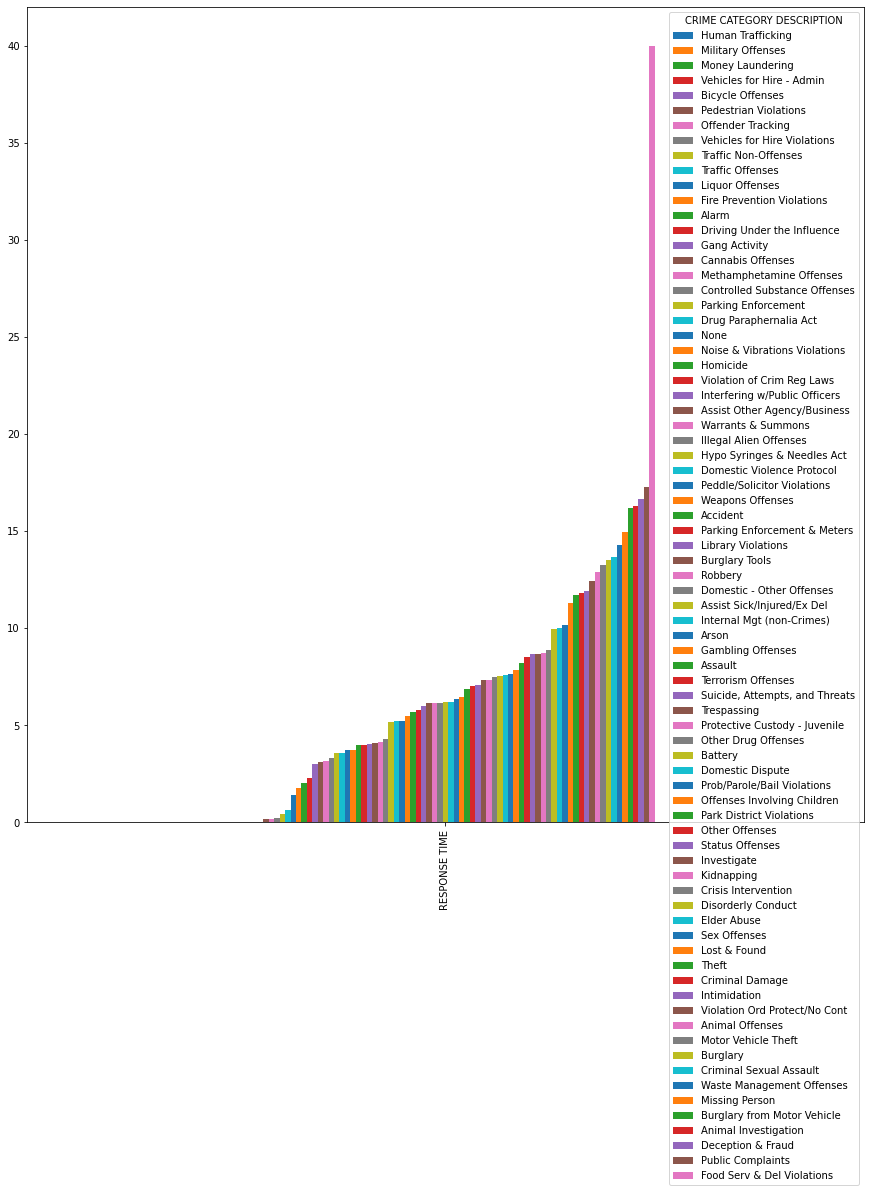

In [7]:
#remove rows with invalid time column value
#this method could take a while!

# simple_df.drop(err)
s = simple_df.pivot_table(values ='RESPONSE TIME', columns=['CRIME CATEGORY DESCRIPTION'], aggfunc=np.mean).sort_values(by='RESPONSE TIME', axis=1)
#s.head()
s.plot.bar(figsize=(15,15))

In [8]:
simple_df.head(10)
t = simple_df[['RESPONSE TIME']]
t = t[t['RESPONSE TIME'].notna()]
t["RESPONSE TIME"].mode()


0    0.0
dtype: float64

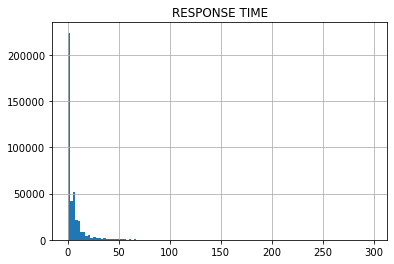

In [9]:
hist = t.hist(bins=120)

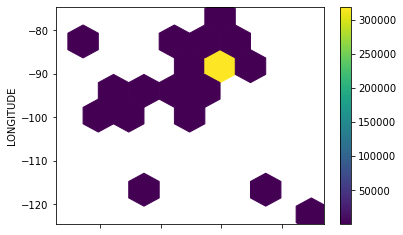

In [10]:
ax = simple_df.plot.hexbin(x='LATITUDE',
                    y='LONGITUDE',
                    C='COUNT',
                    reduce_C_function=np.sum,
                    gridsize=8,
                    cmap="viridis")

In [11]:
incidents_df['CRIME CATEGORY DESCRIPTION'].value_counts()

Traffic Offenses                  149559
Accident                           50031
Theft                              34794
Battery                            25007
Criminal Damage                    20345
Domestic Dispute                   20212
Assist Other Agency/Business       17304
Disorderly Conduct                 13670
Warrants & Summons                 12390
Burglary                           12090
Status Offenses                     9550
Lost & Found                        9195
Interfering w/Public Officers       6359
Liquor Offenses                     5957
Burglary from Motor Vehicle         5876
Deception & Fraud                   5796
Crisis Intervention                 5454
Driving Under the Influence         5026
Animal Offenses                     4956
Trespassing                         4845
Cannabis Offenses                   4521
Vehicles for Hire - Admin           3567
Assault                             3391
Offenses Involving Children         3125
Controlled Subst

In [12]:
incidents_df['BIAS CODE'].value_counts()

88.0    332341
0.0     128550
99.0     13379
11.0       123
12.0        91
41.0        24
14.0        20
42.0        10
54.0         8
24.0         7
43.0         5
31.0         5
32.0         5
3.0          5
33.0         5
55.0         4
15.0         4
44.0         3
26.0         2
51.0         2
53.0         2
8.0          1
90.0         1
25.0         1
21.0         1
9.0          1
52.0         1
Name: BIAS CODE, dtype: int64

In [13]:
incidents_df['BIAS DESCRIPTION'].value_counts()

NONE                             332341
UNKNOWN                           13379
ANTI-WHITE                          123
ANTI-BLACK                           91
ANTI-MALE HOMOSEXUAL(GAY)            24
ANTI-PACIFIC ISLANDER                20
ANTI-FEMALE HOMOSEXUAL(LESB.)        10
ANTI-GENDER FEMALE OLD                8
ANTI-ISLAMIC                          7
ANTI-HOMOSEXUAL(GAY/LESBIAN)          5
ANTI-OTHER ETHNICITY/ORIGIN           5
ANTI-HISPANIC                         5
ANTI-ARAB                             5
ANTI-MULTI-RACIAL GROUP               4
ANTI-HETEROSEXUAL                     3
ANTI-MULTI-RELIGIOUS                  2
ANTI -GENDER MALE OLD                 2
ANTI-PHYSICALLY DISABLED              2
ANTI-JEWISH                           1
ANTI-OTHER RELIGION                   1
ANTI-MENTALLY DISABLED                1
Name: BIAS DESCRIPTION, dtype: int64

In [14]:
bias_df = incidents_df[['BIAS DESCRIPTION','COUNT', 'CRIME CATEGORY', 'CRIME CATEGORY DESCRIPTION']]
bias_df.groupby(['BIAS DESCRIPTION']).sum()


,COUNT
BIAS DESCRIPTION,
ANTI -GENDER MALE OLD,2
ANTI-ARAB,5
ANTI-BLACK,91
ANTI-FEMALE HOMOSEXUAL(LESB.),10
ANTI-GENDER FEMALE OLD,8
ANTI-HETEROSEXUAL,3
ANTI-HISPANIC,5
ANTI-HOMOSEXUAL(GAY/LESBIAN),5
ANTI-ISLAMIC,7
